# Methane Plume Detection from Concentration Map

This notebook implements a workflow to detect and mask methane plumes from a given CH₄ concentration map (e.g., `*_MF_concentration.tif`). The process is based on common techniques used in methane remote sensing, which typically include:

1.  **Background Statistics Estimation**: Calculate robust statistics (median and standard deviation) of the background concentration to distinguish it from plume enhancements.
2.  **Thresholding**: Apply a statistical threshold (e.g., median + N × std. dev.) to create a binary mask of potential plume pixels.
3.  **Morphological Filtering**: Use operations like binary closing and opening to remove noise and connect disparate parts of a single plume.
4.  **Connected Component Analysis**: Group the masked pixels into distinct clusters, each representing a potential plume.
5.  **Plume Filtering**: Remove small, spurious clusters that are unlikely to be real plumes based on a minimum pixel-count threshold.
6.  **Visualization**: Display the final plume mask overlaid on the concentration map.

In [17]:
import sys
import json
import contextlib
import io
from pathlib import Path
import numpy as np
import rasterio
from scipy.ndimage import gaussian_filter, label, binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import datetime

# Ensure the project root is in the Python path to import repository modules
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


def tee_stdout(log_path: Path):
    "Context manager that mirrors stdout to a log file."
    @contextlib.contextmanager
    def _tee():
        buffer = io.StringIO()
        with contextlib.redirect_stdout(buffer):
            yield
        text = buffer.getvalue()
        log_path.parent.mkdir(parents=True, exist_ok=True)
        with open(log_path, "a", encoding="utf-8") as f:
            f.write(text)
        print(text, end="")
    return _tee()


## Configuration

Set the path to your concentration map and define the parameters for plume detection.

In [18]:
# Path to the CH4 concentration GeoTIFF from a pipeline run
# You can use one of the outputs from the demo notebooks or your own data.

#GHGsat
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/C6_24034700_20240112_20241008_Qhp5CqH/C6_24034700_20240112_20241008_Qhp5CqH_CH4.tif"
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/C8_25044052_20240911_20250103_WlbR_JX/C8_25044052_20240911_20250103_WlbR_JX_CH4.tif"
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/C2_25044054_20240228_20250103_9iY6jsy/C2_25044054_20240228_20250103_9iY6jsy_CH4.tif"

#EMIT
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EMIT/full_dataset/EMITL2BCH4ENH_002/EMIT_L2B_CH4ENH_002_20240112T185917_2401212_016.tif"
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/emit/full_dataset/EMITL2BCH4ENH_002-20251117_160414/EMIT_L2B_CH4ENH_002_20240228T043521_2405903_003.tif"

#EnMAP
CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EnMAP/MF_broad/full-column/L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_full-column_MF.tif"
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/enmap/MF_broad/full-column/L1B_DT0000092488_001_20240911T075547Z_20240911T075552Z_full-column_MF.tif"

#PRISMA
#CONCENTRATION_MAP_PATH = "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Turkmenistan_20240911/prisma/MF_broad/full-column/PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_full-column_MF_concentration.tif"


# --- Parameters for Plume Detection ---

# Number of standard deviations above the median to set the threshold
SIGMA_THRESHOLD = 1.40 

# Sigma for the Gaussian filter to apply before thresholding (smoothing)
# Set to 0 to disable smoothing.
SMOOTHING_SIGMA = 2.8  

# Minimum number of pixels for a cluster to be considered a plume
MIN_PLUME_PIXELS = 40

# --- Morphological Kernel Configuration ---
MORPH_KERNEL_SHAPE = 'disk'  # 'square' or 'disk'
MORPH_KERNEL_SIZE =  7     # Side for square, radius for disk   

## Plume Detection Function

In [19]:
def create_plume_mask(
    concentration_map: np.ndarray,
    sigma_threshold: float = 3.0,
    smoothing_sigma: float = 0.0,
    min_plume_pixels: int = 10,
    morph_structure: np.ndarray = np.ones((3, 3)),
    connectivity_structure: np.ndarray = np.ones((3, 3)),
    invalid_mask: np.ndarray | None = None,
) -> np.ndarray:
    """Detects methane plumes in a concentration map.

    Args:
        concentration_map: 2D NumPy array of methane concentration.
        sigma_threshold: Number of standard deviations above the median for thresholding.
        smoothing_sigma: Sigma for Gaussian smoothing before thresholding. 0 to disable.
        min_plume_pixels: Minimum number of pixels to be considered a plume.
        morph_structure: Structuring element for morphological operations.
        connectivity_structure: Structuring element for the labeling/connectivity step.
                                Must have dimensions of size 3 (e.g., 3x3).
        invalid_mask: Boolean mask where True marks nodata/invalid pixels to exclude.

    Returns:
        A 2D boolean NumPy array with True for plume pixels.
    """
    if invalid_mask is None:
        invalid_mask = ~np.isfinite(concentration_map)
    valid_mask = ~invalid_mask

    # 1. (Optional) Apply Gaussian smoothing to reduce noise
    if smoothing_sigma > 0:
        smoothed_map = gaussian_filter(concentration_map, sigma=smoothing_sigma)
    else:
        smoothed_map = concentration_map.copy()

    # 2. Estimate background statistics (robustly) on valid pixels only
    valid_pixels = smoothed_map[valid_mask & np.isfinite(smoothed_map)]
    background_median = np.median(valid_pixels)
    background_std = np.std(valid_pixels)
    threshold = background_median + sigma_threshold * background_std
    print(f"Background Median: {background_median:.4f}")
    print(f"Background Std Dev: {background_std:.4f}")
    print(f"Plume Threshold: {threshold:.4f}")

    # 3. Apply threshold to get initial mask, ignoring invalid pixels
    initial_mask = (smoothed_map > threshold) & valid_mask

    # 4. Morphological filtering to clean up noise
    closed_mask = binary_closing(initial_mask, structure=morph_structure)
    cleaned_mask = binary_opening(closed_mask, structure=morph_structure)

    # 5. Connected component analysis to find clusters
    labeled_array, num_features = label(cleaned_mask, structure=connectivity_structure)
    print(f"Found {num_features} potential plume clusters before filtering.")

    # 6. Filter clusters by size
    final_mask = np.zeros_like(cleaned_mask, dtype=bool)
    if num_features > 0:
        cluster_sizes = np.bincount(labeled_array.ravel())[1:]  # Ignore background 0
        plume_labels = np.where(cluster_sizes >= min_plume_pixels)[0] + 1
        # Keep the N largest plumes
        largest_labels = plume_labels[np.argsort(cluster_sizes[plume_labels - 1])[::-1][:10]]
        final_mask = np.isin(labeled_array, largest_labels)
        print(f"Kept {len(largest_labels)} largest plumes after filtering.")

    # Ensure invalid pixels are never flagged as plume
    final_mask &= valid_mask
    return final_mask, labeled_array


## Execution and Visualization

Output directory created at: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EnMAP/MF_broad/full-column/plume_segmentation


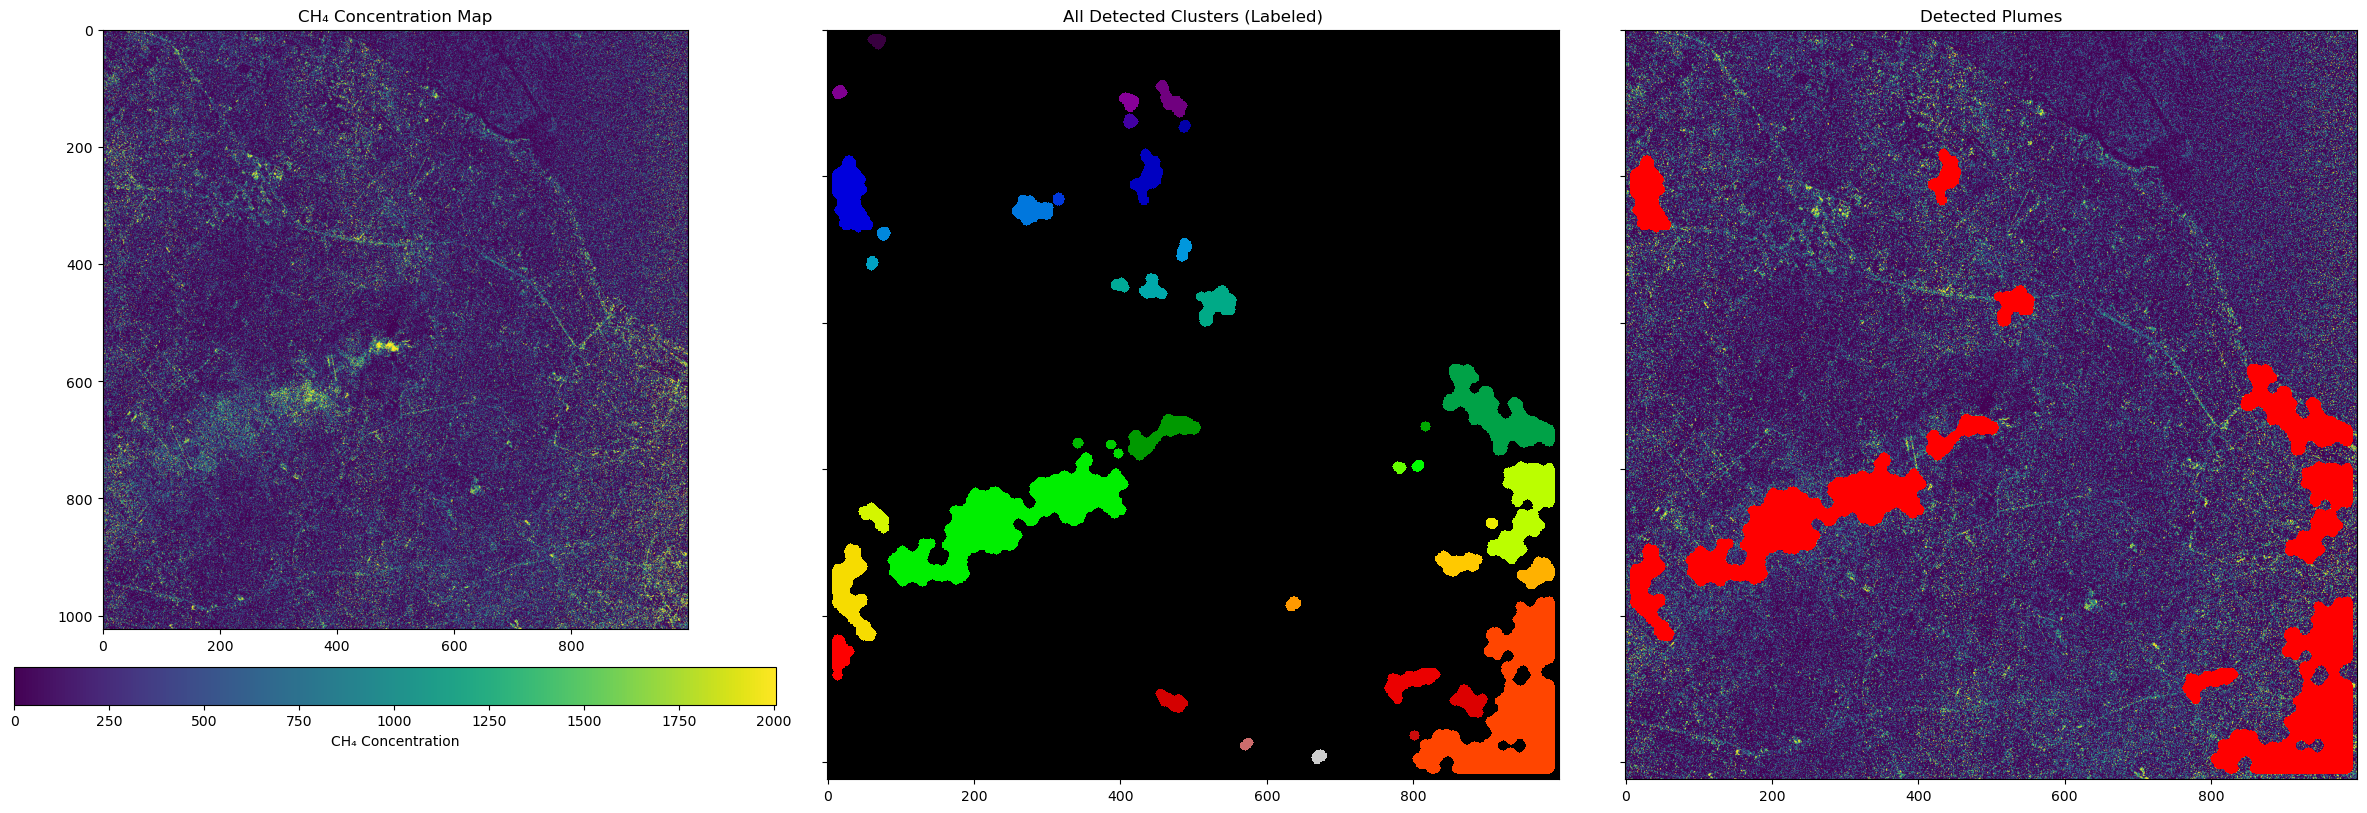

Background Median: 280.7624
Background Std Dev: 130.0313
Plume Threshold: 462.8062
Found 40 potential plume clusters before filtering.
Kept 10 largest plumes after filtering.
Plume mask saved to: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EnMAP/MF_broad/full-column/plume_segmentation/L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_full-column_MF_plume_mask.tif
Polygonized plumes saved to: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EnMAP/MF_broad/full-column/plume_segmentation/L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_full-column_MF_plumes.geojson
Figure saved to: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/EnMAP/MF_broad/full-column/plume_segmentation/run_2025-11-26T19-04-48/figure_01.png


In [20]:
### --- 1. Configuration & Setup ---
input_path = Path(CONCENTRATION_MAP_PATH)
output_dir = input_path.parent / "plume_segmentation"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory created at: {output_dir}")

base_name = input_path.stem
output_mask_path = output_dir / f"{base_name}_plume_mask.tif"
output_geojson_path = output_dir / f"{base_name}_plumes.geojson"

if MORPH_KERNEL_SHAPE == 'square':
    morph_structure = np.ones((MORPH_KERNEL_SIZE, MORPH_KERNEL_SIZE), dtype=bool)
elif MORPH_KERNEL_SHAPE == 'disk':
    morph_structure = disk(MORPH_KERNEL_SIZE)

# --- Run bookkeeping ---
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
run_dir = output_dir / f"run_{timestamp}"
run_dir.mkdir(parents=True, exist_ok=True)
params = {
    "CONCENTRATION_MAP_PATH": CONCENTRATION_MAP_PATH,
    "SIGMA_THRESHOLD": SIGMA_THRESHOLD,
    "SMOOTHING_SIGMA": SMOOTHING_SIGMA,
    "MIN_PLUME_PIXELS": MIN_PLUME_PIXELS,
    "MORPH_KERNEL_SHAPE": MORPH_KERNEL_SHAPE,
    "MORPH_KERNEL_SIZE": MORPH_KERNEL_SIZE,
}
(run_dir / "params.json").write_text(json.dumps(params, indent=2), encoding="utf-8")
stdout_log = run_dir / "stdout.txt"

with tee_stdout(stdout_log):
    ### --- 2. Load Data and Run Detection ---
    with rasterio.open(input_path) as src:
        concentration_map = src.read(1, masked=False)
        profile = src.profile
        transform = src.transform
        crs = src.crs
        nodata_val = src.nodata

    invalid_mask = ~np.isfinite(concentration_map)
    if nodata_val is not None:
        invalid_mask |= concentration_map == nodata_val

    concentration_map_clean = concentration_map.copy()
    concentration_map_clean[concentration_map_clean < 0] = 0  # clamp negatives
    concentration_map_clean[invalid_mask] = 0  # keep nodata from skewing stats

    plume_mask, labeled_array = create_plume_mask(
        concentration_map_clean,
        sigma_threshold=SIGMA_THRESHOLD,
        smoothing_sigma=SMOOTHING_SIGMA,
        min_plume_pixels=MIN_PLUME_PIXELS,
        morph_structure=morph_structure,
        invalid_mask=invalid_mask,
    )

    ### --- 3. Save Raster Mask ---
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
    if 'nodata' in profile:
        del profile['nodata']

    with rasterio.open(output_mask_path, 'w', **profile) as dst:
        dst.write(plume_mask.astype(rasterio.uint8), 1)
    print(f"Plume mask saved to: {output_mask_path}")

    ### --- 4. Polygonize Largest Plumes and Save GeoJSON ---
    if np.any(plume_mask):
        plume_shapes = shapes(plume_mask.astype(np.uint8), mask=plume_mask, transform=transform)
        geometries = [shape(s) for s, v in plume_shapes if v == 1]
        gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)
        gdf.to_file(output_geojson_path, driver='GeoJSON')
        print(f"Polygonized plumes saved to: {output_geojson_path}")

    ### --- 5. Visualization ---
    valid_pixels = concentration_map_clean[np.isfinite(concentration_map_clean)]
    vmax = np.percentile(valid_pixels, [99])
    vmin = 0

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    axes[0].imshow(concentration_map_clean, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title('CH₄ Concentration Map')
    fig.colorbar(axes[0].images[0], ax=axes[0], orientation='horizontal', pad=0.05, label='CH₄ Concentration')

    axes[1].imshow(labeled_array, cmap='nipy_spectral', interpolation='none')
    axes[1].set_title('All Detected Clusters (Labeled)')

    masked_display = np.ma.masked_where(~plume_mask, plume_mask)
    axes[2].imshow(concentration_map_clean, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[2].imshow(masked_display, cmap='autumn', interpolation='none')
    axes[2].set_title('Detected Plumes')

    for ax in axes:
        ax.set_aspect('equal')

    plt.tight_layout()
    fig_path = run_dir / "figure_01.png"
    fig.savefig(fig_path, dpi=200, bbox_inches="tight")
    print(f"Figure saved to: {fig_path}")
    plt.show()
